In [2]:
!pip3 install neattext
!pip3 install emoji
!pip3 install simple_colors

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 114.7/114.7 kB 1.2 MB/s eta 0:00:000:00:01m eta 0:00:01

[notice] A new release of pip available: 22.3 -> 22.3.1
[notice] To update, run: pip install --upgrade pip

[notice] A new release of pip available: 22.3 -> 22.3.1
[notice] To update, run: pip install --upgrade pip

[notice] A new release of pip available: 22.3 -> 22.3.1
[notice] To update, run: pip install --upgrade pip


In [3]:
import neattext.functions as nfx
import matplotlib.pyplot as plt
import pandas as pd
import numpy as np
import string
import emoji
import json
import nltk

from sklearn.metrics import accuracy_score, confusion_matrix, classification_report, plot_confusion_matrix
from sklearn.feature_extraction.text import CountVectorizer, TfidfVectorizer
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LogisticRegression
from sklearn.tree import DecisionTreeClassifier
from sklearn.naive_bayes import MultinomialNB

from wordcloud import WordCloud, ImageColorGenerator
from collections import Counter
from simple_colors import *
from PIL import Image

from nltk.stem import WordNetLemmatizer
from nltk.corpus import stopwords
from nltk.corpus import wordnet

from google.colab import drive
drive.mount('/content/drive')

nltk.download('stopwords')
nltk.download('wordnet')
nltk.download('averaged_perceptron_tagger')

# dir = "/content/drive/MyDrive/Colab Notebooks/Data Mining/HW2/data/"
dir = "./data"
split_path = dir + "data_identification.csv"
emotion_path = dir + "emotion.csv"
data_path = dir + "tweets_DM.json"
train_path = dir + "train.csv"
test_path = dir + "test.csv"

ModuleNotFoundError: No module named 'neattext'

In [4]:
emotion = pd.read_csv(emotion_path)
emotion = emotion.convert_dtypes()
print("emotion: ", emotion.shape)
print(emotion["emotion"].value_counts())
print("=====================\n")
split = pd.read_csv(split_path)
print("split: ", split.shape)
print(split["identification"].value_counts())

emotion:  (1455563, 2)
joy             516017
anticipation    248935
trust           205478
sadness         193437
disgust         139101
fear             63999
surprise         48729
anger            39867
Name: emotion, dtype: Int64

split:  (1867535, 2)
train    1455563
test      411972
Name: identification, dtype: int64


In [8]:
# load data
train_data = pd.read_csv(train_path, lineterminator='\n')
test_data = pd.read_csv(test_path, lineterminator='\n')

print("train: ", train_data.shape)
print("test: ", test_data.shape)

# drop unuse column
train_data.drop(["hashtags"], axis=1, inplace=True)
test_data.drop(["hashtags"], axis=1, inplace=True)

# cleaning dataset
train_data["tweet_id"] = train_data["tweet_id"].astype(str)
train_data["text"] = train_data["text"].astype(str)
test_data["tweet_id"] = test_data["tweet_id"].astype(str)
test_data["text"] = test_data["text"].astype(str)

# drop missing values
train_data.dropna(inplace=True)
test_data.dropna(inplace=True)

# drop duplicates
train_data.drop_duplicates(keep="first", inplace=True)
test_data.drop_duplicates(keep="first", inplace=True)

print("\ncleaned train: ", train_data.shape)
print("cleaned test: ", test_data.shape)
train_data.head(5)

train:  (1455563, 4)
test:  (411972, 3)

cleaned train:  (1455563, 3)
cleaned test:  (411972, 2)


,tweet_id,text,emotion
0,0x376b20,"People who post ""add me on #Snapchat"" must be ...",anticipation
1,0x2d5350,"@brianklaas As we see, Trump is dangerous to #...",sadness
2,0x1cd5b0,Now ISSA is stalking Tasha 😂😂😂 <LH>,fear
3,0x1d755c,@RISKshow @TheKevinAllison Thx for the BEST TI...,joy
4,0x2c91a8,Still waiting on those supplies Liscus. <LH>,anticipation


In [9]:
## Cleaning the text data
data = train_data

# remove userhandles
data["text_userhandles"] = data["text"].apply(nfx.remove_userhandles)

# lower casing
data["text_lower"] = data["text_userhandles"].str.lower()

# handle emoji
data["text_emoji"] = data["text_lower"].apply(lambda text: emoji.demojize(text))

# remove puntuation
punc_to_remove = string.punctuation

def remove_punctuation(text):
    return text.translate(str.maketrans('','', punc_to_remove))
data["text_punc"] = data["text_emoji"].apply(lambda text: remove_punctuation(text))

# remove stopwords
STOPWORDS = set(stopwords.words("english"))

def remove_stopword(text):
    return " ".join([word for word in str(text).split() if word not in STOPWORDS])
data["text_stop"] = data["text_punc"].apply(lambda text: remove_stopword(text))

# remove unwanted words
unwanted_words = ["lh"]
text = lambda x: ' '.join(w for w in x.split() if not w in unwanted_words)
data["cleantext"] = data['text_stop'].apply(text)

# check total columns of the dataset before cleaning
print("Dataset Features (Before): " ,data.columns.tolist())

# remove unnecessary columns
data.drop(['text_lower', 'text_userhandles', 'text_punc', 'text_emoji', 'text_stop'], axis=1, inplace=True)

# check total columns of the dataset to ensure unnecessary columns are deleted - successful
print("Dataset Features (After) : " ,data.columns.tolist())

Dataset Features (Before):  ['tweet_id', 'text', 'emotion', 'text_userhandles', 'text_lower', 'text_emoji', 'text_punc', 'cleantext']
Dataset Features (After) :  ['tweet_id', 'text', 'emotion', 'cleantext']


In [12]:
print(data.shape)
data.head(10)

(1455563, 4)


,tweet_id,text,emotion,cleantext
0,0x376b20,"People who post ""add me on #Snapchat"" must be ...",anticipation,people post add snapchat must dehydrated cuz m...
1,0x2d5350,"@brianklaas As we see, Trump is dangerous to #...",sadness,see trump dangerous freepress around world tru...
2,0x1cd5b0,Now ISSA is stalking Tasha 😂😂😂 <LH>,fear,issa stalking tasha facewithtearsofjoyfacewith...
3,0x1d755c,@RISKshow @TheKevinAllison Thx for the BEST TI...,joy,thx best time tonight stories heartbreakingly ...
4,0x2c91a8,Still waiting on those supplies Liscus. <LH>,anticipation,still waiting supplies liscus
5,0x368e95,Love knows no gender. 😢😭 <LH>,joy,love knows gender cryingfaceloudlycryingface
6,0x249c0c,@DStvNgCare @DStvNg More highlights are being ...,sadness,highlights shown actual sports watches triathl...
7,0x359db9,The #SSM debate; <LH> (a manufactured fantasy ...,anticipation,ssm debate manufactured fantasy used distract ...
8,0x23b037,I love suffering 🙃🙃 I love when valium does no...,joy,love suffering upsidedownfaceupsidedownface lo...
9,0x1fde89,Can someone tell my why my feeds scroll back t...,anger,someone tell feeds scroll back 30 tweets saw 1...


# Simple Model for Sequence Classification

- Naive Bayes Model
  - Word Frequency (CountVector)
  - TFiDF feature
- Logistic Regression
- Decision Tree

In [17]:
Xfeature = data["cleantext"]
Ylabel = data["emotion"]

cv = CountVectorizer()
X = cv.fit_transform(Xfeature)

X_train, X_test, y_train, y_test = train_test_split(X, Ylabel, test_size=0.2, random_state=42)
print("Train:", X_train.shape, y_train.shape)
print("Test :", X_test.shape, y_test.shape)

Train: (1164450, 706550) (1164450,)
Test : (291113, 706550) (291113,)


In [18]:
# Naive Bayes Model with CountVectorizer

nvModel = MultinomialNB()
nvModel.fit(X_train, y_train)

print("Length of the model classes: ", len(nvModel.classes_))
print("Type of the model classes  : ", nvModel.classes_)
print("Model accuracy on train set : ", nvModel.score(X_train, y_train))
print("Model accuracy on test set : ", nvModel.score(X_test, y_test))

Length of the model classes:  8
Type of the model classes  :  ['anger' 'anticipation' 'disgust' 'fear' 'joy' 'sadness' 'surprise'
 'trust']
Model accuracy on train set :  0.5982910386877925
Model accuracy on test set :  0.5141439921954705


In [20]:
tfidf = TfidfVectorizer()
XX = cv.fit_transform(Xfeature)

X_train, X_test, y_train, y_test = train_test_split(XX, Ylabel, test_size=0.2, random_state=42)
print("Train:", X_train.shape, y_train.shape)
print("Test :", X_test.shape, y_test.shape)

Train: (1164450, 706550) (1164450,)
Test : (291113, 706550) (291113,)


In [21]:
# Naive Bayes Model with TfidfVectorizer

nvtModel = MultinomialNB()
nvtModel.fit(X_train, y_train)

print("Length of the model classes: ", len(nvtModel.classes_))
print("Type of the model classes  : ", nvtModel.classes_)
print("Model accuracy on train set : ", nvtModel.score(X_train, y_train))
print("Model accuracy on test set : ", nvtModel.score(X_test, y_test))

Length of the model classes:  8
Type of the model classes  :  ['anger' 'anticipation' 'disgust' 'fear' 'joy' 'sadness' 'surprise'
 'trust']
Model accuracy on train set :  0.5982910386877925
Model accuracy on test set :  0.5141439921954705


In [ ]:
lrModel = LogisticRegression()
lrModel.fit(X_train, y_train)

print("Length of the model classes: ", len(lrModel.classes_))
print("Type of the model classes  : ", lrModel.classes_)
print("Model accuracy             : ", lrModel.score(X_test, y_test)) 

In [ ]:
dtModel = DecisionTreeClassifier(max_depth =10, random_state = 42)
dtModel.fit(X_train, y_train)

print("Length of the model classes: ", len(dtModel.classes_))
print("Type of the model classes  : ", dtModel.classes_)
print("Model accuracy             : ", dtModel.score(X_test, y_test)) 

In [ ]:
# Model Evaluation

# naive bayes 
plot_confusion_matrix(nvtModel, X_test, y_test, cmap="Blues")
plt.title("Confusion Matrix for Naive Bayes Classification")
plt.show()

# logistic regression
plot_confusion_matrix(lrModel, X_test, y_test, cmap="Blues")
plt.title("Confusion Matrix for Logistic Regression")
plt.show()

# decision tree

plot_confusion_matrix(dtModel, X_test, y_test, cmap="Blues")
plt.title("Confusion Matrix for Logistic Regression")
plt.show()

# Find Emotion Keywords

1. Extract text data based on its emotion
2. Use Counter() in nltk to find the most common words in the category
3. Use WordCloud to visualize the keywords in each emotion

In [31]:
# Print Emotion Keywords

def extract_keywords(text, num = 100):
    tokens = [tok for tok in text.split()]
    most_common_tokens = Counter(tokens).most_common(num)
    return dict(most_common_tokens)

# extract joy keywords
joyList = data[data['emotion'] == 'joy']['cleantext'].tolist()    # create a joy list 
joyDoc = ' '.join(joyList)                                      # create a joy document which store all the joy words in list
joyKeywords = extract_keywords(joyDoc)                          # extract the keywords

# extract anger keywords
angerList = data[data['emotion'] == 'anger']['cleantext'].tolist() 
angerDoc = ' '.join(angerList)                                   
angerKeywords = extract_keywords(angerDoc)   

# extract fear keywords
fearList = data[data['emotion'] == 'fear']['cleantext'].tolist() 
fearDoc = ' '.join(fearList)                                   
fearKeywords = extract_keywords(fearDoc)   

# extract sadness keywords
sadnessList = data[data['emotion'] == 'sadness']['cleantext'].tolist() 
sadnessDoc = ' '.join(sadnessList)                                   
sadnessKeywords = extract_keywords(sadnessDoc)

# extract anticipation keywords
anticipationList = data[data['emotion'] == 'anticipation']['cleantext'].tolist() 
anticipationDoc = ' '.join(anticipationList)                                   
anticipationKeywords = extract_keywords(anticipationDoc)

# extract disgust keywords
disgustList = data[data['emotion'] == 'disgust']['cleantext'].tolist() 
disgustDoc = ' '.join(disgustList)                                   
disgustKeywords = extract_keywords(disgustDoc)

# extract trust keywords
trustList = data[data['emotion'] == 'trust']['cleantext'].tolist() 
trustDoc = ' '.join(trustList)                                   
trustKeywords = extract_keywords(trustDoc)  

# extract surprise keywords
surpriseList = data[data['emotion'] == 'surprise']['cleantext'].tolist() 
surpriseDoc = ' '.join(surpriseList)                                   
surpriseKeywords = extract_keywords(surpriseDoc)  

In [32]:
def plot_wordcloud(docx):
    mywordcloud = WordCloud(background_color="white").generate(docx)
    plt.figure(figsize = (13,10))
    plt.imshow(mywordcloud, interpolation = 'bilinear')
    plt.axis('off')
    plt.show()

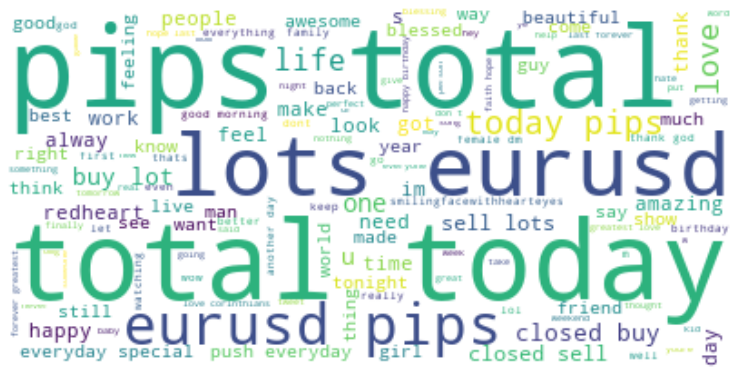

In [33]:
plot_wordcloud(joyDoc)

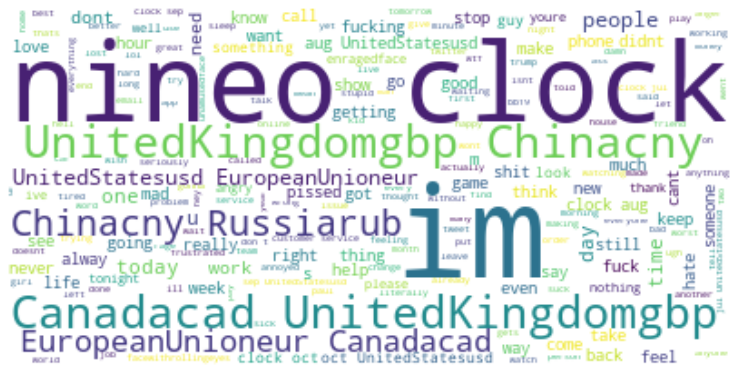

In [34]:
plot_wordcloud(angerDoc)

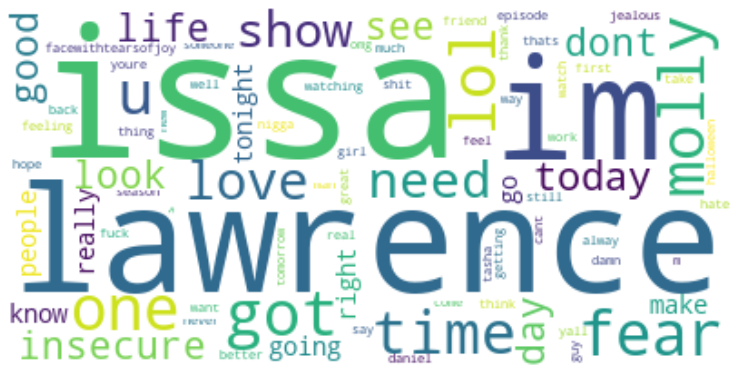

In [35]:
plot_wordcloud(fearDoc)

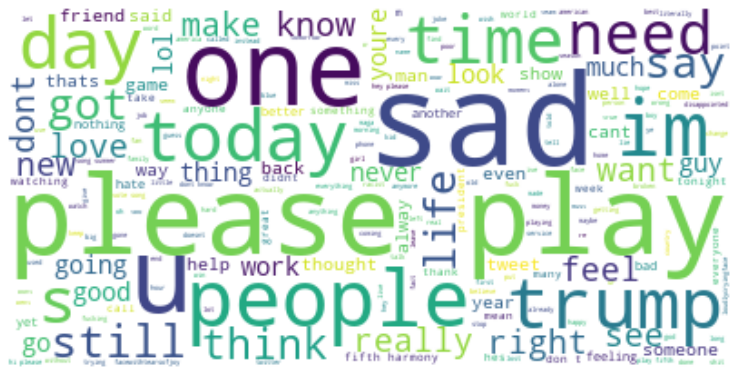

In [36]:
plot_wordcloud(sadnessDoc)

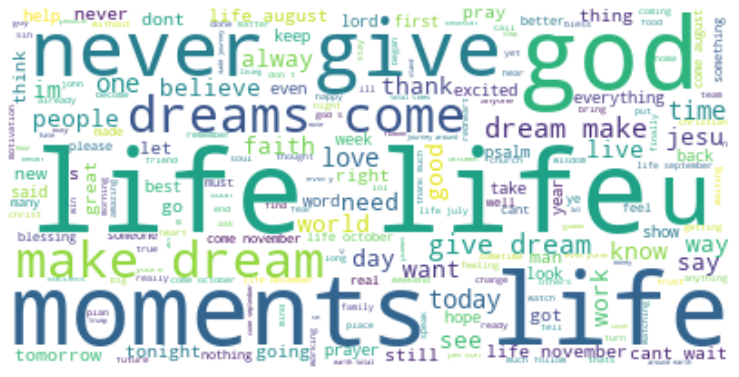

In [37]:
plot_wordcloud(anticipationDoc)

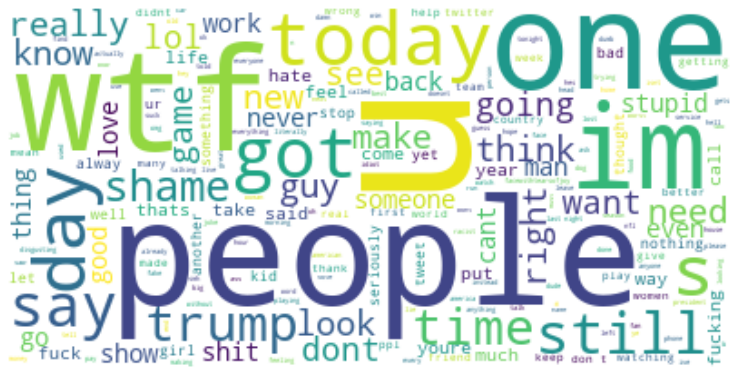

In [38]:
plot_wordcloud(disgustDoc)

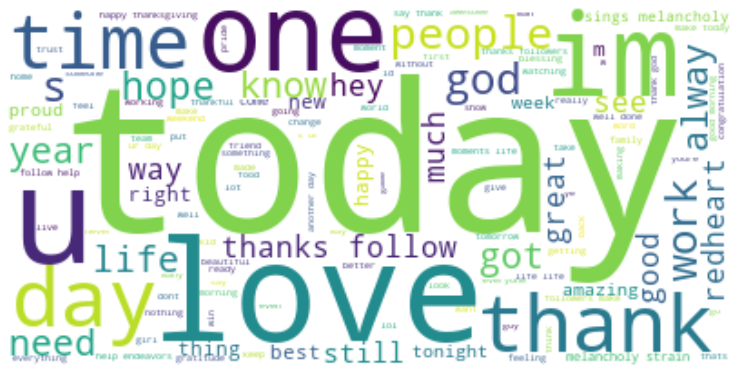

In [39]:
plot_wordcloud(trustDoc)

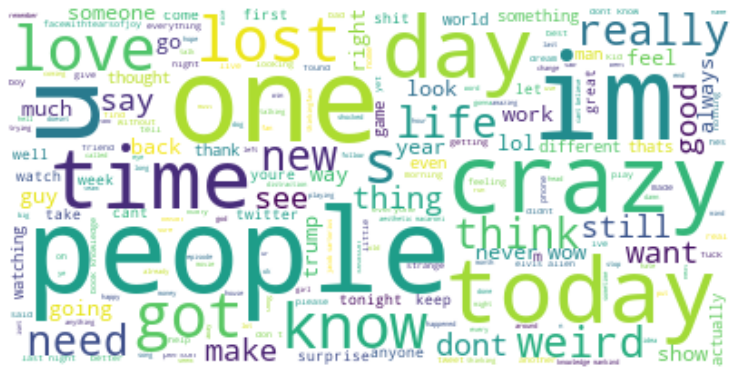

In [40]:
plot_wordcloud(surpriseDoc)